In [31]:
import json
import os
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import dot
from numpy.linalg import norm
from resume_fields import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from resume_fields import *
from tqdm import tqdm

In [4]:
with open("parsed_resume_jsons/parsed_resumes_llama2_current.json") as f:
    llama2 = json.load(f)
    
with open("parsed_resume_jsons/new_chatgpt.json") as f:
    chatgpt = json.load(f)
    
print(len(llama2))
print(len(chatgpt))

11852
14312


In [6]:
llama2 = {k: v for k, v in llama2.items() if k in chatgpt}
chatgpt = {k: v for k, v in chatgpt.items() if k in llama2}
keys = list(llama2.keys())
print(len(llama2))
print(len(chatgpt))

11186
11186


In [38]:
a = """abc def
ghu"""
a.split()

['abc', 'def', 'ghu']

In [40]:
[x[RESPONSIBILITIES] for x in llama2[keys[0]][EXPERIENCE]]
problematic_llama = []
similarities = {k: {"similarities": [], "len_resume": 0} for k in keys}
for k in tqdm(keys):
    res_len = len(getCleanResume(k).split(" "))
    try:
        llama_responsibilities = [x[RESPONSIBILITIES] for x in llama2[k][EXPERIENCE]]
        chat_responsibilities = [x[RESPONSIBILITIES] for x in chatgpt[k][EXPERIENCE]]
    except Exception as e:
        problematic_llama.append(k)
        continue
    for lr, cr in zip(llama_responsibilities, chat_responsibilities):
        similarities[k]["similarities"].append(compute_cosine_similarity(lr, cr))
        similarities[k]["len_resume"] = res_len
    

100%|██████████| 11186/11186 [03:38<00:00, 51.15it/s]


In [80]:
problematic_llama = set(problematic_llama)
len(problematic_llama) / len(keys)

0.016896120150187734

In [35]:
problematic_llama[38]

'14838.txt'

In [36]:
llama2["14838.txt"][EXPERIENCE]

[{'Job_Title': 'Consultant/Owner',
  'Company': 'MVWORKS LLC',
  'Location': 'July 2017 to Present',
  'Start_Date': 'Serve small-business and residential clients by developing and providing value-added software and consulting services at cost-effective rates. Manage all aspects of the business including bookkeeping, advertising, vendor & product research, client quotes and sales. Perform system repair and support service as well as structured wiring in homes and offices.',
  'End_Date': ''},
 {'Job_Title': 'IT Systems Administrator',
  'Company': 'AVR Inc',
  'Location': 'April 2017 to August 2018',
  'Start_Date': 'Monitor, maintain and assist with improvements or repairs to the network infrastructure and all servers in production. Provide remote and in-person support for IT clients and for company personnel. Work to improve current service for the IT clients by improving overall security and management of notifications as well as setup automated processes for maintenance tasks to im

In [47]:
# change similarities to mean of similarities
similarities = {k: {"similarities": np.mean(v["similarities"]), "len_resume": v["len_resume"]} for k, v in similarities.items()}
similarities = pd.DataFrame(similarities).T

In [48]:
similarities.describe()

,similarities,len_resume
count,10997.000000,11186.000000
mean,0.941197,470.214018
std,0.233729,173.221981
min,0.000000,0.000000
25%,0.938037,319.000000
50%,0.997042,478.000000
75%,1.000000,611.000000
max,2.000000,910.000000


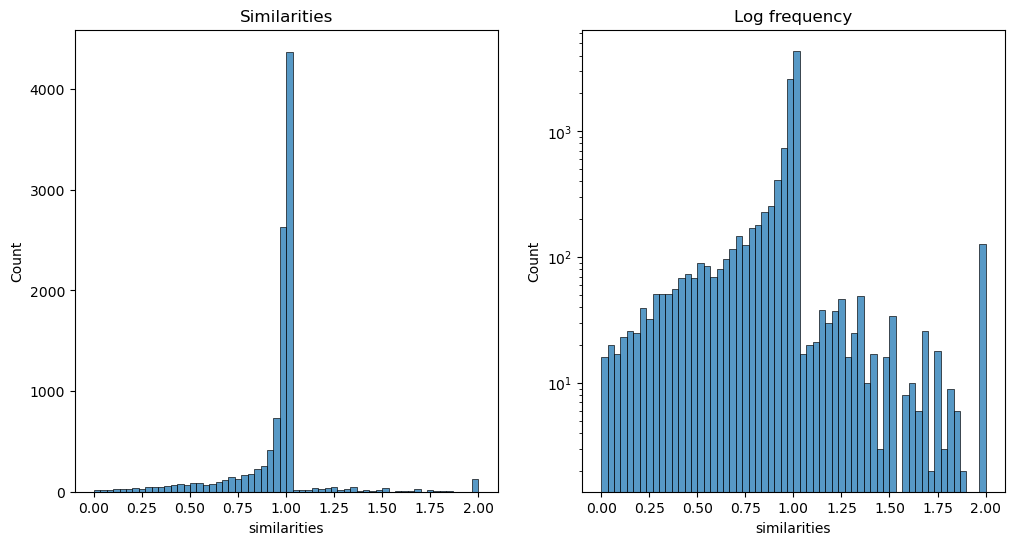

In [77]:
# plog similarities on regular scale and log scale on different subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(similarities["similarities"], ax=axs[0], bins=60)
axs[0].set_title("Similarities")
sns.histplot(similarities["similarities"], ax=axs[1], bins=60)
axs[1].set_yscale("log")
axs[1].set_title("Log frequency")
plt.show()


In [78]:
print(res_format)

{
    "Basic_Info": {
        "Current_Title": "",
        "Current_Company": "",
        "Location": "",
        "Bio": ""
    },
    "Experience": [
        {
            "Job_Title": "",
            "Company": "",
            "Location": "",
            "Start_Date": "",
            "End_Date": "",
            "Responsibilities": ""
        }
    ],
    "Education": [
        {
            "Degree": "",
            "Field": "",
            "Institution": "",
            "Location": "",
            "Graduation_Date": ""
        }
    ],
    "Projects": [
        {
            "Project_Title": "",
            "Description": "",
            "Date": ""
        }
    ],
    "Skills": [],
    "Technical_Skills": [],
    "Links": [],
    "Certifications": [
        {
            "Certification_Title": "",
            "Issuing_Organization": "",
            "Date_Issued": ""
        }
    ],
    "Awards": [
        {
            "Award_Title": "",
            "Issuing_Organization": ""
    

In [94]:
# see how oftern the models agree on company names, start dates, end dates, and titles
problematic_chat = set()
agreed = {k: {"Company": [], "Job_Title": [], "Location": [], "Start_Date": [], "End_Date": [] } for k in keys}
for k in tqdm(keys):
    llama_experience = llama2[k][EXPERIENCE]
    chat_experience = chatgpt[k][EXPERIENCE]
    for le, ce in zip(llama_experience, chat_experience):
        for field in [COMPANY, JOB_TITLE, LOCATION, START_DATE, END_DATE]:
            if field not in le or field not in ce:
                if field not in le:
                    print(f"{k} does not have {field} in llama")
                    problematic_llama.add(k)
                if field not in ce:
                    problematic_chat.add(k)
                    print(f"{k} does not have {field} in chat")
                continue
                    #problematic_chat.add(k)
            if le[field].upper() == ce[field].upper():
                agreed[k][field].append(1)
            else:
                agreed[k][field].append(0)

100%|██████████| 11186/11186 [00:00<00:00, 130049.99it/s]

03910.txt does not have Start_Date in llama
14208.txt does not have Start_Date in llama
16589.txt does not have Start_Date in llama
16589.txt does not have Start_Date in llama
16723.txt does not have Start_Date in chat
02059.txt does not have Start_Date in llama
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
06561.txt does not have Start_Date in chat
04299.txt does not have End_Date in llama
04299.txt does not have End_Date in llama
04299.txt does not have End_Date in llama
04299.txt does not have End_Date in llama
04299.txt does not have End_Date in llama
25536.txt does not have End_Date in llama
03900.txt does not have Start_Date in llama
20057.txt does not have Start_Date in llama
11071.txt does not have End_Date in llama
17349.txt does not have Start_Date in chat
27503.txt d

In [113]:
agreed
# change agreed to mean of agreed. Also record weight as the length of the list
agreed_rate = {
    k: {
        **{field: np.mean(v[field]) for field in v.keys()},
        "weights": len(next(iter(v.values())))
    } 
    for k, v in agreed.items()
}
agreed_rate = pd.DataFrame(agreed_rate).T
agreed_rate

/opt/anaconda3/envs/resume_research/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/resume_research/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Company,Job_Title,Location,Start_Date,End_Date,weights
21770.txt,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
08995.txt,1.000000,1.000000,1.000000,1.000000,1.000000,3.0
03249.txt,1.000000,1.000000,1.000000,1.000000,1.000000,5.0
03114.txt,1.000000,1.000000,1.000000,1.000000,1.000000,6.0
02107.txt,1.000000,1.000000,1.000000,0.800000,0.800000,5.0
...,...,...,...,...,...,...
14584.txt,1.000000,1.000000,1.000000,1.000000,1.000000,3.0
03651.txt,0.222222,0.333333,0.333333,0.333333,0.333333,9.0
15043.txt,0.800000,0.800000,0.100000,0.100000,0.100000,10.0
09939.txt,1.000000,1.000000,1.000000,1.000000,1.000000,7.0


In [120]:
agreed_rate.describe()

,Company,Job_Title,Location,Start_Date,End_Date,weights
count,11186.000000,11186.000000,11186.000000,11165.000000,11125.000000,11186.000000
mean,0.884343,0.881076,0.739835,0.786113,0.800021,3.768818
std,0.236712,0.239065,0.376076,0.369816,0.360515,1.785557
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.875000,0.857143,0.500000,0.666667,0.750000,3.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000


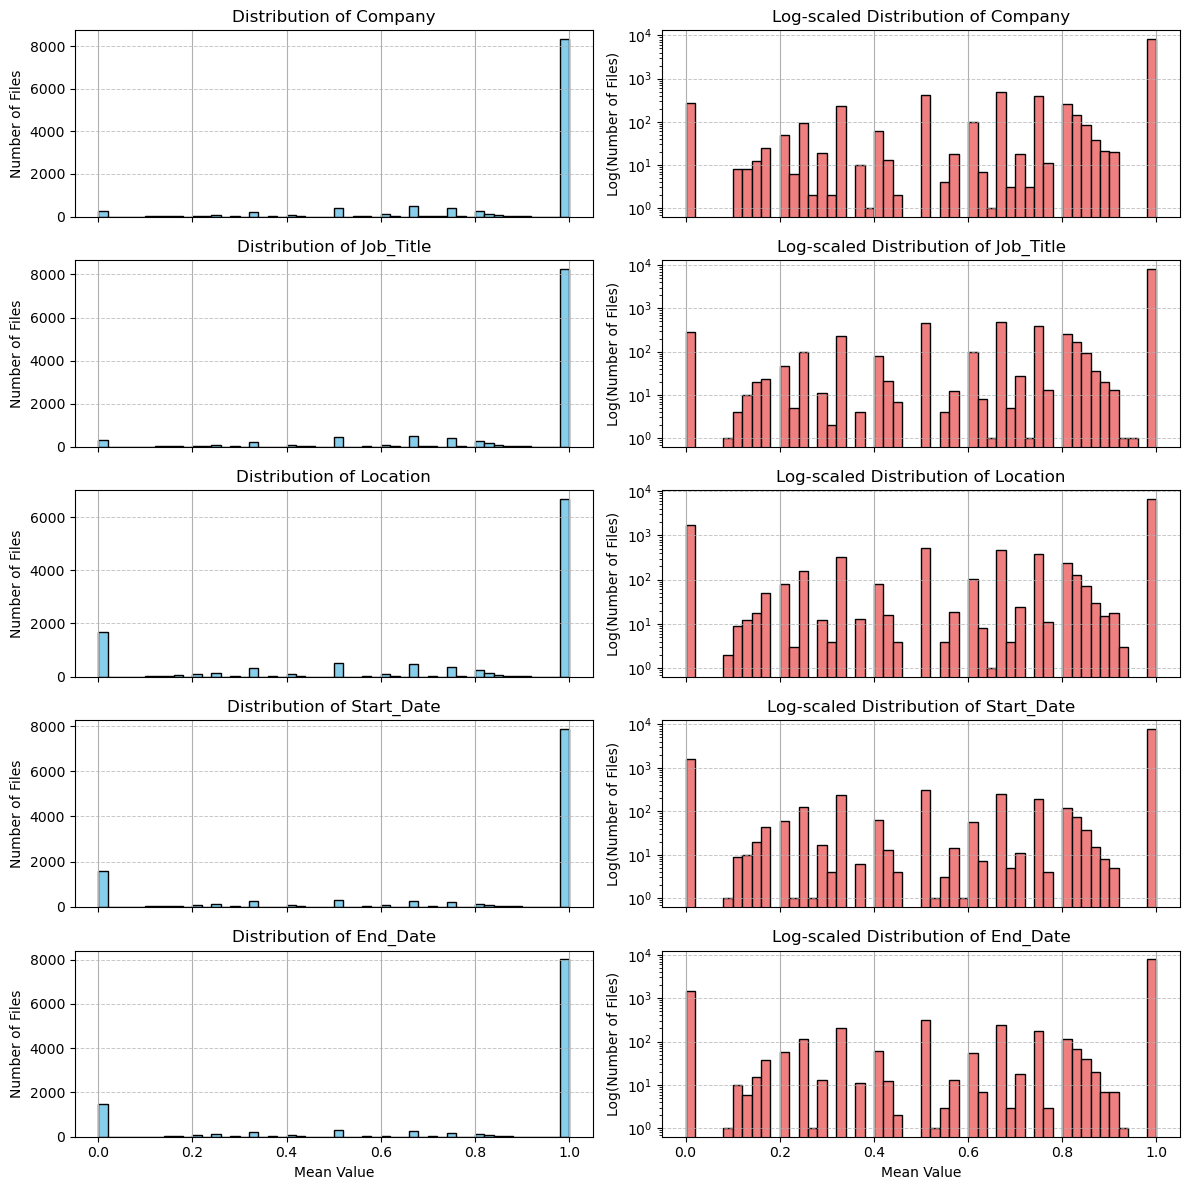

In [123]:
# Plotting histograms for each field

fig, axs = plt.subplots(5, 2, figsize=(12, 12), sharex=True)
fields = ['Company', 'Job_Title', 'Location', 'Start_Date', 'End_Date']

for i, field in enumerate(fields):
    # Regular y-axis histogram
    agreed_rate[field].hist(ax=axs[i, 0], bins=50, edgecolor='black', color='skyblue')
    axs[i, 0].set_title(f'Distribution of {field}')
    axs[i, 0].set_ylabel('Number of Files')
    axs[i, 0].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Log-scaled y-axis histogram
    agreed_rate[field].hist(ax=axs[i, 1], bins=50, edgecolor='black', color='lightcoral')
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_title(f'Log-scaled Distribution of {field}')
    axs[i, 1].set_ylabel('Log(Number of Files)')
    axs[i, 1].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

axs[-1, 0].set_xlabel('Mean Value')
axs[-1, 1].set_xlabel('Mean Value')
plt.tight_layout()
plt.show()



# Compare skills

In [140]:
#skills = {key : {"llama2": set([x.upper() for x in llama2[key]['Skills'] + llama2[key]['Technical_Skills']]), "chatgpt": set([x.upper() for x in chatgpt[key]['Skills'] + chatgpt[key]['Technical_Skills']])} for key in keys}
skills = {k: {"intersection": 0, "union": 0} for k in keys}
for k in keys:
    try: 
        llama_skill = set([x.upper() for x in llama2[k]['Skills'] + llama2[k]['Technical_Skills']])
    except:
        print(k, "llama")
        problematic_llama.add(k)
        continue
    try:
        chat_skill = set([x.upper() for x in chatgpt[k]['Skills'] + chatgpt[k]['Technical_Skills']])
    except:
        print(k, "chat")
        problematic_chat.add(k)
        continue
    
    skills[k]['intersection'] = len(llama_skill.intersection(chat_skill)) + 1e-5
    skills[k]['union'] = len(llama_skill.union(chat_skill)) + 1e-5
skills = pd.DataFrame(skills).T
skills["ratio"] = skills["intersection"] / skills["union"]

28079.txt llama
09792.txt llama
07279.txt chat
19613.txt chat
16591.txt llama
01314.txt llama
09139.txt chat
15307.txt chat
17209.txt llama
27808.txt chat
19895.txt llama
08969.txt chat
06168.txt chat
21087.txt chat
19823.txt llama
25980.txt llama
03704.txt chat
25832.txt chat
09118.txt llama
14051.txt llama
04162.txt llama


In [141]:
skills

,intersection,union,ratio
21770.txt,21.00001,21.00001,1.000000e+00
08995.txt,17.00001,17.00001,1.000000e+00
03249.txt,0.00001,10.00001,9.999990e-07
03114.txt,5.00001,24.00001,2.083337e-01
02107.txt,11.00001,11.00001,1.000000e+00
...,...,...,...
14584.txt,0.00001,39.00001,2.564102e-07
03651.txt,15.00001,15.00001,1.000000e+00
15043.txt,0.00001,0.00001,1.000000e+00
09939.txt,18.00001,39.00001,4.615386e-01


In [147]:
skills.describe().round(3)

,intersection,union,ratio
count,11186.000,11186.000,11165.000
mean,6.391,14.217,0.561
std,7.331,11.869,0.442
min,0.000,0.000,0.000
25%,0.000,5.000,0.000
50%,5.000,11.000,0.706
75%,10.000,20.000,1.000
max,70.000,150.000,1.000
